In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor)
import sys
import os, random

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *

/Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
 /Users/jake/Python/causal_prospective_merge/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

varying_sample_sizes = [100, 120, 140, 160, 180, 200]
fixed_n_complementary = 100
n_host = 100 
 # set to None if both candidates have the same sample size


n_rct_before_split = 10**5
std_true_y = 1
sigma_prior = 1
sigma_rand_error = 1
include_intercept = 1  # 0 if no intercept
power_x, power_x_t = 1, 1

np.random.seed(42)
random.seed(42)

X0 = np.random.beta(12, 3, size=n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions = {"X_0": X0, "X_1": X1, "X_2": X2}
d = (
    include_intercept
    + len(x_distributions) * (power_x)
    + 1
    + len(x_distributions) * (power_x_t)
)

p_assigned_to_host = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)
p_assigned_to_cand2 = lambda X, T, eps: sigmoid(
    1 + 2 * X["X_0"] - X["X_1"] + 2 * T + eps
)


causal_param_first_index = power_x*len(x_distributions) + include_intercept 

outcome_function = (
    # y = 1 + 1*X_0 - 1*X_1 + 1*X_2 + 4*T + 2*X_0*T + 2*X_1*T + 0*X_2*T + eps
    lambda X, T, eps: include_intercept  # intercept, non-causal => 0 no intercept
    + 1 * X["X_0"]  # non-causal
    - 1 * X["X_1"]  # non-causal
    + 1 * X["X_2"]  # non-causal
    + 5 * T  # causal
    + 2 * X["X_0"] * T  # causal
    + 2 * X["X_1"] * T  # causal
    - 4 * X["X_2"] * T  # causal
    + eps
)

CATE_function = lambda X: outcome_function(X,np.ones(len(X)), 0 )-outcome_function(X,np.zeros(len(X)),0)

if include_intercept:
    true_params = np.array([1, 1, -1, 1, 4, 2, 2, 0])  # intercept, non-causal => 0
else:
    true_params = np.array([1, -1, 1, 4, 2, 2, 0])  # copied from above
std_true_y = 1  # Standard deviation for the true Y

Simulation parameters

In [3]:
# Prior parameters for Bayesian update on host
if include_intercept:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0, 0])
else:
    prior_mean = np.array([0, 0, 0, 0, 0, 0, 0])
assert len(prior_mean) == d, "Shape error"

beta_0, sigma_0_sq, inv_cov_0 = (
    prior_mean,
    sigma_rand_error**2,
    1 / sigma_prior * np.eye(len(prior_mean)),
)
prior_hyperparameters = {
    "beta_0": beta_0,
    "sigma_0_sq": sigma_0_sq,
    "inv_cov_0": inv_cov_0,
}


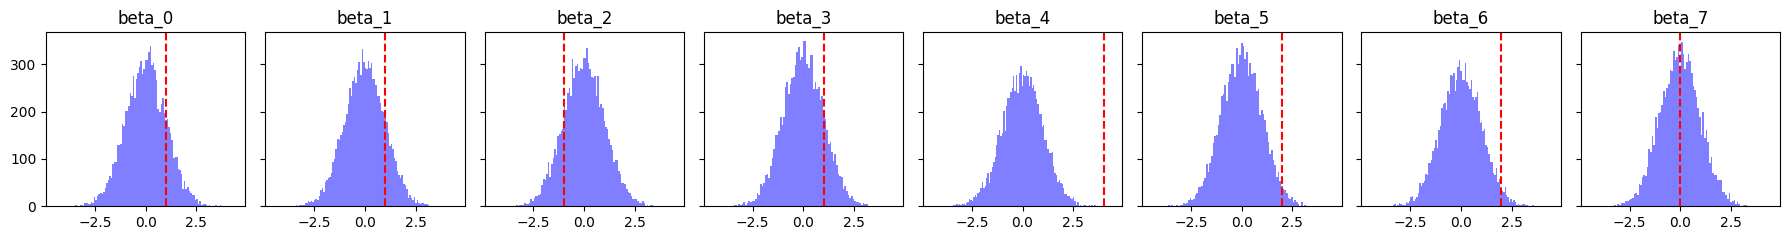

In [4]:
# only meaningful if the outcome model is linear 

# sample from the prior:
beta_samples = rng.multivariate_normal(
    prior_mean, cov=sigma_prior * np.eye(len(prior_mean)), size=10000
)
# plot the prior samples and true_params as red crosses:
# let's do d subplots
ax, fig = plt.subplots(1, d, figsize=(18, 2.5), sharex=True, sharey=True)

# on each subplot, plot the prior samples and the true params
for i in range(d):
    fig[i].hist(beta_samples[:, i], bins=100, alpha=0.5, color="blue")
    fig[i].axvline(true_params[i], color="red", linestyle="--")
    fig[i].set_title(f"beta_{i}")

plt.tight_layout()
plt.show()

In [5]:
n_seeds = 50
data_parameters = {
    "fixed_n_complementary": fixed_n_complementary,
    "varying_sample_sizes": varying_sample_sizes,
    "n_rct_before_split": n_rct_before_split,
    "x_distributions": x_distributions,
    "p_assigned_to_cand2": p_assigned_to_cand2,
    "p_assigned_to_host": p_assigned_to_host,
    "n_host": n_host,
    "power_x": power_x,
    "power_x_t": power_x_t,
    "outcome_function": outcome_function,
    "std_true_y": std_true_y,
    "causal_param_first_index": causal_param_first_index,
}

### 2. EIG closed form 

In [6]:
# exact_data = generate_exact_data_varying_sample_size(
#     data_parameters, include_intercept=bool(include_intercept)
# )
# dict_additional_plots_obs_closed_from, dict_additional_plots_caus_closed_from = (
#     linear_eig_closed_form_varying_sample_size(
#         exact_data,
#         data_parameters,
#         prior_hyperparameters,
#     )
# )

In [7]:
EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []
store_non_exact_data = {}

for i in range(n_seeds):
    nonexact_data = generate_data_varying_sample_size(
        data_parameters, include_intercept=bool(include_intercept), seed=i)
    EIGs = linear_eig_closed_form_varying_sample_size(  # CHECK what this does
        nonexact_data,
        data_parameters,
        prior_hyperparameters,
        verbose=False,
    )
    EIG_obs_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_closed_form_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )
    store_non_exact_data[i] = nonexact_data


EIG_obs_closed_form_across_seeds = np.vstack(EIG_obs_closed_form_across_seeds)  
EIG_caus_closed_form_across_seeds = np.vstack(EIG_caus_closed_form_across_seeds)


,intercept,X_0,X_1,X_2,T,T*X_0,T*X_1,T*X_2,Y
0,1.0,0.825415,4.246403,0.035583,1.0,0.825415,4.246403,0.035583,10.158498
1,1.0,0.812954,2.420428,0.050076,1.0,0.812954,2.420428,0.050076,12.328058
2,1.0,0.882727,3.285393,0.000525,1.0,0.882727,3.285393,0.000525,8.603135
3,1.0,0.928734,3.015026,0.005124,1.0,0.928734,3.015026,0.005124,10.829667
4,1.0,0.679560,2.185114,0.045727,1.0,0.679560,2.185114,0.045727,9.657130
...,...,...,...,...,...,...,...,...,...
1995,1.0,0.854937,3.490335,0.285670,1.0,0.854937,3.490335,0.285670,13.017324
1996,1.0,0.773229,3.411528,0.009277,1.0,0.773229,3.411528,0.009277,12.690059
1997,1.0,0.862866,2.674810,0.051278,0.0,0.000000,0.000000,0.000000,-1.837122
1998,1.0,0.932044,3.306639,0.054536,0.0,0.000000,0.000000,0.000000,-2.532377


In [8]:
def turn_into_diff(arr):
    n, d = np.shape(arr)[0], np.shape(arr)[1]
    result = np.zeros((n//2, d))
    for i in range (n//2):
        result[i,:]=arr[2*i,:]-arr[(2*i) +1,:]
    return result

proportions = np.array(varying_sample_sizes)/fixed_n_complementary
proportions

array([1. , 1.2, 1.4, 1.6, 1.8, 2. ])

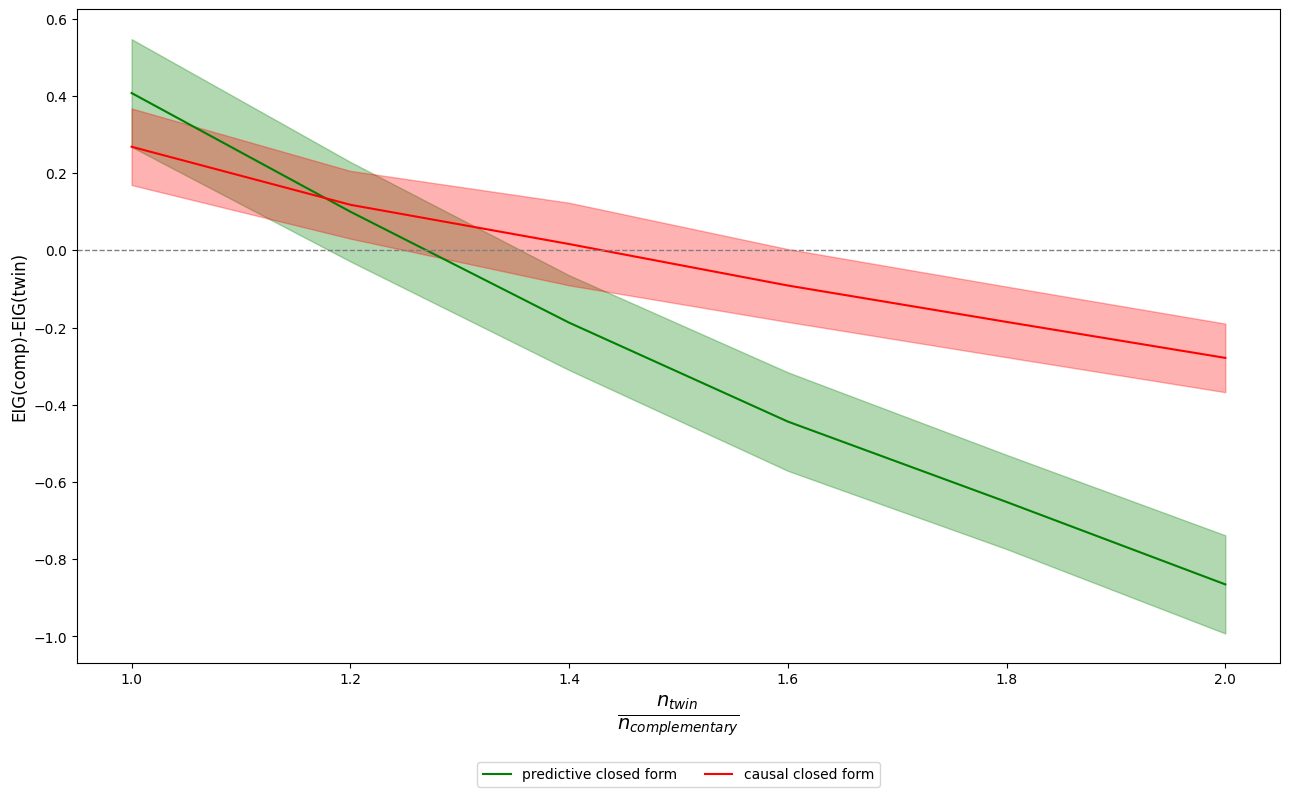

In [9]:
dict_diff_EIG_closed_form_across_seeds = {'predictive closed form': turn_into_diff(EIG_obs_closed_form_across_seeds),\
                                         'causal closed form':turn_into_diff(EIG_caus_closed_form_across_seeds)}


color_dict = {'predictive closed form': 'green', 'causal closed form': 'red'}

plot_dict(
    x = proportions,
    dict = dict_diff_EIG_closed_form_across_seeds,
    axis_names=[r'$\frac{n_{twin}}{n_{complementary}}$', 'EIG(comp)-EIG(twin)', "Mean MSE difference"],
    dict_additional_plots=None,
    title= None,
    color_dict=color_dict,
    save=None
)


### 2. EIG from samples for varying sample sizes

In [10]:
n_samples_outer_expectation_obs = 200
n_samples_inner_expectation_obs = 400
n_samples_outer_expectation_caus = 400
n_samples_inner_expectation_caus = 800

sampling_parameters = {
    "n_samples_inner_expectation_obs": n_samples_inner_expectation_obs,
    "n_samples_outer_expectation_obs": n_samples_outer_expectation_obs,
    "n_samples_inner_expectation_caus": n_samples_inner_expectation_caus,
    "n_samples_outer_expectation_caus": n_samples_outer_expectation_caus,
}

In [11]:
# dict_additional_plots_obs_from_samples, dict_additional_plots_caus_from_samples = (
#     linear_eig_from_samples_varying_sample_size(
#         exact_data,
#         data_parameters,
#         prior_hyperparameters,
#         sampling_parameters
#     )
# )

# EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []


# EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
# EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)

In [12]:
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range(n_seeds):
    EIGs = linear_eig_from_samples_varying_sample_size(
        store_non_exact_data[i], data_parameters, prior_hyperparameters, sampling_parameters
    )
    EIG_obs_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[0].values()]
    )
    EIG_caus_samples_across_seeds.append(
        [cand_values for cand_values in EIGs[1].values()]
    )

EIG_obs_samples_across_seeds = np.vstack(EIG_obs_samples_across_seeds)  
EIG_caus_samples_across_seeds = np.vstack(EIG_caus_samples_across_seeds)


KeyboardInterrupt: 

In [ ]:

# diff_EIG_obs_samples_across_seeds = {'complementary - twin': turn_into_diff(EIG_obs_samples_across_seeds)}
# diff_EIG_caus_samples_across_seeds = {'complementary - twin': turn_into_diff(EIG_caus_samples_across_seeds)}

# plot_dict(
#     x = varying_sample_sizes,
#     dict = diff_EIG_obs_samples_across_seeds,
#     axis_names=["Sample size of candidate datasets", "EIG obs closed form"],
#     dict_additional_plots=None,
#     text=None,
#     title= "EIG obs from samples"
# )

# plot_dict(
#     x = varying_sample_sizes,
#     dict = diff_EIG_caus_samples_across_seeds,
#     axis_names=["Sample size of candidate datasets", "EIG obs closed form"],
#     dict_additional_plots=None,
#     text=None,
#     title= "EIG caus from samples"
# )


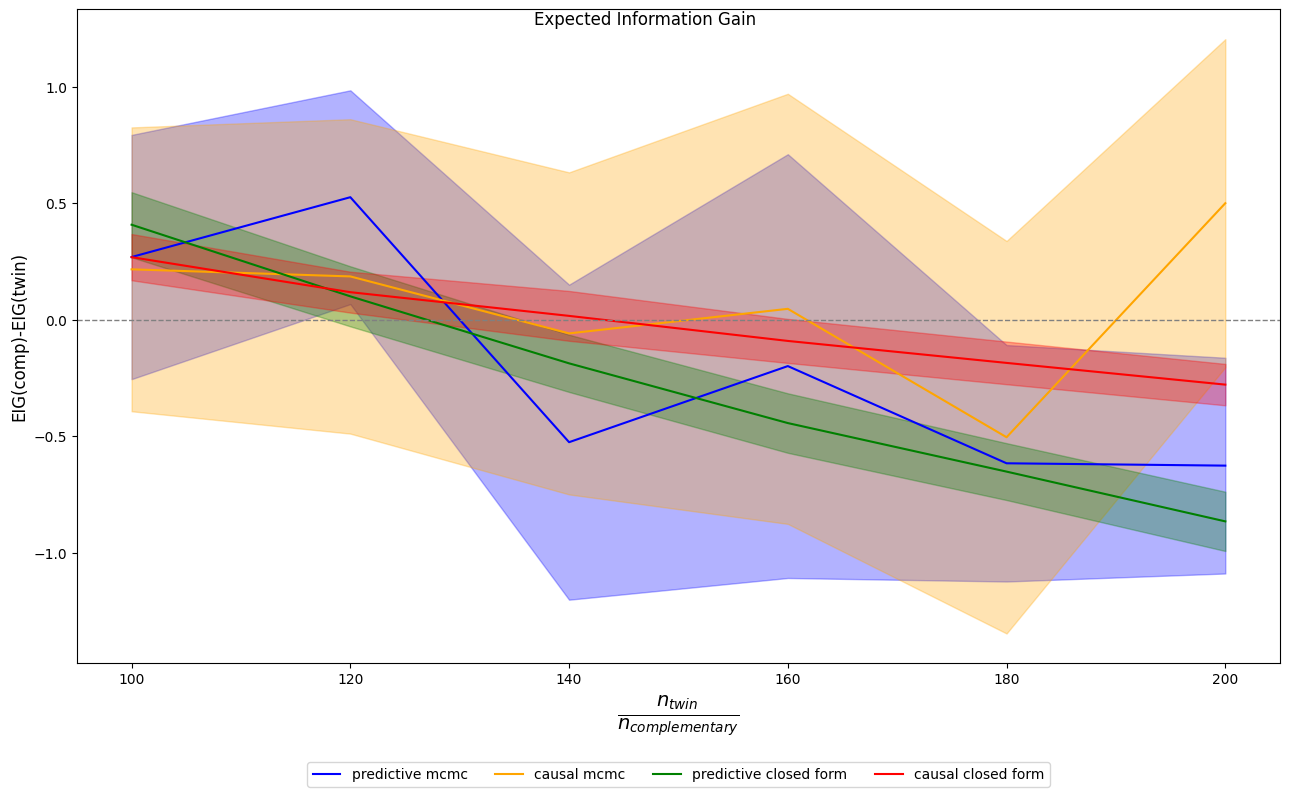

In [ ]:
dict_all_diff = {'predictive mcmc': turn_into_diff(EIG_obs_samples_across_seeds), 'causal mcmc': turn_into_diff(EIG_caus_samples_across_seeds), \
                 'predictive closed form': turn_into_diff(EIG_obs_closed_form_across_seeds), 'causal closed form': turn_into_diff(EIG_caus_closed_form_across_seeds)}
color_dict = {'predictive mcmc': 'blue', 'causal mcmc': 'orange', \
                 'predictive closed form': 'green', 'causal closed form': 'red'}
plot_dict(
    x = varying_sample_sizes,
    dict = dict_all_diff,
    color_dict = color_dict,
    axis_names=[r'$\frac{n_{twin}}{n_{complementary}}$', 'EIG(comp)-EIG(twin)', "Mean MSE difference"],
    dict_additional_plots=None,
    text=None,
    title= "Expected Information Gain",
)

### Ground truth : merging and fit Y

In [57]:
data_parameters_copy = data_parameters.copy()
data_parameters_copy["n_host"]=2000
data_parameters_copy["varying_sample_sizes"] = [0]
data = generate_data_varying_sample_size(
        data_parameters_copy, include_intercept=bool(include_intercept), seed=100)
host_test = data[0]["host"]
X_host,Y_host = host_test.drop(columns=['Y']), host_test['Y']

In [58]:
merged_datasets = {i:{} for i in range (len(store_non_exact_data.keys()))}

for seed, seed_data_dict in store_non_exact_data.items():
    for sample_size, data_dict in seed_data_dict.items():
        merged_data_dict={}
        for name, data in data_dict.items():
            if name != 'host':
                merged_data_dict[name]= pd.concat([data_dict['host'], data_dict[name]], axis=0)
        merged_datasets[seed][sample_size] = merged_data_dict

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


merged_mse = {sample_size:{'complementary':[], 'cand2':[],'complementary_CATE':[], 'cand2_CATE':[]} for sample_size in varying_sample_sizes}

for seed, seed_data_dict in merged_datasets.items():
    for sample_size, data_dict in seed_data_dict.items():  
        for cand_name, data in data_dict.items():
            X, Y = data.drop(columns=['Y']), data['Y']
            model = LinearRegression()
            model.fit(X,Y,)
            Y_pred = model.predict(X_host)
            mse = mean_absolute_error(Y_host, Y_pred)
            merged_mse[sample_size][cand_name].append(mse)
            # CATE from here on
            true_cate = CATE_function(X_host)

            X_zero = X_host.copy()
            X_zero.iloc[:,4:] = 0
            X_one = X_host.copy()
            X_one.iloc[:,4:] = X_host.iloc[:,:4]

            pred_cate = model.predict(X_one) - model.predict(X_zero)
            mse_CATE = mean_absolute_error(true_cate, pred_cate)
            merged_mse[sample_size][cand_name+"_CATE"].append(mse_CATE)



mean_mse = {"pred":[],"CATE":[]}
for seed, seed_data_dict in merged_mse.items():
    mse_array = pd.DataFrame.from_dict(seed_data_dict).values
    mse_array_pred = mse_array[:,1] - mse_array[:,0]#twin - complementary: Error(twin) < Error(complementary) for n_twin > n_complementary
    mse_array_CATE = mse_array[:,2] - mse_array[:,3] 
    mean_mse['pred'].append(np.mean(mse_array_pred))
    mean_mse['CATE'].append(np.mean(mse_array_CATE))

print(mean_mse)


{'pred': [0.01869143176933501, -0.00018926947493239866, -0.002807424059781429, -0.001940843623567663, -0.002751989757728901, -0.0039439865459962855], 'CATE': [-0.13858709161314503, -0.012389606463603466, 0.00567825880923058, -0.0056535628450560945, 0.006241940543232456, 0.025901997451654234]}


In [34]:
pd.DataFrame.from_dict(seed_data_dict).values

array([[0.89720841, 0.82323182, 0.17115327, 0.15296815],
       [0.74536393, 0.75143105, 0.2655223 , 0.28514123],
       [0.84407821, 0.82785853, 0.22784164, 0.25008642],
       [0.73487001, 0.8124737 , 0.1646686 , 0.30162463],
       [0.74003928, 0.79011645, 0.31765206, 0.20358442],
       [0.78092687, 0.79241166, 0.32107692, 0.13769197],
       [0.70836719, 0.67708913, 0.24683563, 0.22275268],
       [0.81732819, 0.74637316, 0.2619568 , 0.10070168],
       [0.73040893, 0.76257595, 0.14954276, 0.18397727],
       [0.75683249, 0.73406344, 0.32960505, 0.12088045],
       [0.88776109, 0.83264015, 0.34383847, 0.28926323],
       [0.83400804, 0.85390366, 0.39844418, 0.09691289],
       [0.81664699, 0.81571877, 0.2282542 , 0.18229792],
       [0.74019763, 0.73775836, 0.18831664, 0.17566579],
       [0.78788229, 0.79666152, 0.31188582, 0.10165303],
       [0.76999944, 0.8217035 , 0.36999799, 0.50205527],
       [0.77170896, 0.825678  , 0.32371849, 0.26149351],
       [0.81399767, 0.80875585,

In [31]:
pd.DataFrame.from_dict(seed_data_dict).mean()

complementary         0.790791
cand2                 0.783266
complementary_CATE    0.230829
cand2_CATE            0.201491
dtype: float64

In [ ]:
X_zero = X.copy()
X_zero.iloc[:,4:] = 0

In [ ]:
X_one = X.copy()
X_one.iloc[:,4:] = X.iloc[:,:4]

In [ ]:
X_one

,intercept,X_0,X_1,X_2,T,T*X_0,T*X_1,T*X_2
0,1.0,0.846031,3.619991,0.005186,1.0,0.846031,3.619991,0.005186
1,1.0,0.882727,3.285393,0.000525,1.0,0.882727,3.285393,0.000525
2,1.0,0.900395,3.309680,0.321600,1.0,0.900395,3.309680,0.321600
3,1.0,0.928734,3.015026,0.005124,1.0,0.928734,3.015026,0.005124
4,1.0,0.859955,3.719215,0.014101,1.0,0.859955,3.719215,0.014101
...,...,...,...,...,...,...,...,...
504,1.0,0.858715,5.439970,0.064209,1.0,0.858715,5.439970,0.064209
505,1.0,0.747320,3.136450,0.030949,1.0,0.747320,3.136450,0.030949
508,1.0,0.689962,3.565747,0.089652,1.0,0.689962,3.565747,0.089652
509,1.0,0.884689,3.625164,0.093673,1.0,0.884689,3.625164,0.093673


In [ ]:
model

LinearRegression()